In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
import lime
import lime.lime_tabular
import shap

In [190]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [191]:
X_train = pd.read_csv('./X_train.csv')
X_test = pd.read_csv('./X_test.csv')
X_val = pd.read_csv('./X_val.csv')

y_train = pd.read_csv('./Y_train.csv')
y_test = pd.read_csv('./Y_test.csv')
y_val = pd.read_csv('./Y_val.csv')

In [192]:
X_train.head(1)

,city,state,stars,review_count_x,avg_review_stars,review_count_y,total_useful_votes,elite_user_count,review_count_per_bussiness,avg_fans_per_reviewer,checkin_count,tip_count,total_compliments,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BikeParking,RestaurantsTakeOut,WiFi,Caters,WheelchairAccessible,BusinessParking,RestaurantsPriceRange2,weekly_hours
0,Clearwater,FL,2.0,20,1.85,20,26,20,44.1,1.75,10.0,0.0,0.0,1,0,1,0,1,1,0,0,1,1.0,126.0


In [193]:
X_train = X_train.drop(['state','city','review_count_y','stars','elite_user_count','total_useful_votes'], axis=1)
X_val = X_val.drop(['state','city','review_count_y','stars','elite_user_count','total_useful_votes'], axis=1)
X_test = X_test.drop(['state','city','review_count_y','stars','elite_user_count','total_useful_votes'], axis=1)

One Hot Encoding on categorical data

In [194]:
# Apply pd.get_dummies() to both X_train and X_test
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)
X_val_encoded= pd.get_dummies(X_val)
# Align the columns of X_test to match X_train
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
X_val_encoded = X_val_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

In [195]:
X_train_encoded.fillna(0, inplace=True)
X_test_encoded.fillna(0, inplace=True)
X_val_encoded.fillna(0, inplace=True)


In [196]:
y_train.value_counts(normalize=True) * 100

is_open
1          79.614664
0          20.385336
Name: proportion, dtype: float64

In [197]:
X_train_encoded.isnull().sum()

review_count_x                0
avg_review_stars              0
review_count_per_bussiness    0
avg_fans_per_reviewer         0
checkin_count                 0
tip_count                     0
total_compliments             0
RestaurantsDelivery           0
OutdoorSeating                0
BusinessAcceptsCreditCards    0
BikeParking                   0
RestaurantsTakeOut            0
WiFi                          0
Caters                        0
WheelchairAccessible          0
BusinessParking               0
RestaurantsPriceRange2        0
weekly_hours                  0
dtype: int64

In [198]:
print(X_train_encoded.shape)
print(y_train.shape)

(90207, 18)
(90207, 1)


In [199]:
# Drop rows with null values in X_train_encoded
X_train_encoded_clean = X_train_encoded.dropna()

# Make sure to drop corresponding rows in y_train using the same index
y_train_clean = y_train.loc[X_train_encoded_clean.index]

In [200]:
print(X_train_encoded_clean.shape)
print(y_train_clean.shape)

(90207, 18)
(90207, 1)


Applying SMOTE to training data

In [201]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_encoded_clean, y_train_clean)

In [202]:
y_train_smote.value_counts(normalize=True) * 100

is_open
0          50.0
1          50.0
Name: proportion, dtype: float64

AdaBoost

In [203]:
ada_boost_classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42)
ada_boost_classifier.fit(X_train_smote, y_train_smote)

c:\Users\LEGION\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   random_state=42)

In [204]:
# Make predictions on the training data
y_train_pred_adab = ada_boost_classifier.predict(X_train_smote)

In [205]:
# Calculate and print training accuracy
training_accuracy = accuracy_score(y_train_smote, y_train_pred_adab)
print(f"Training Accuracy: {training_accuracy:.4f}")

Training Accuracy: 0.8058


In [206]:
X_test_encoded = pd.get_dummies(X_test)
#Align the columns of X_test to match X_train
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

In [208]:
# Predict on val data
y_pred_ada_boost = ada_boost_classifier.predict(X_val_encoded)

# Evaluate the model
print("Adaboost Accuracy:", accuracy_score(y_val, y_pred_ada_boost))
print(classification_report(y_val, y_pred_ada_boost))

Adaboost Accuracy: 0.7537745261057532
              precision    recall  f1-score   support

           0       0.41      0.49      0.45      6130
           1       0.86      0.82      0.84     23940

    accuracy                           0.75     30070
   macro avg       0.64      0.66      0.65     30070
weighted avg       0.77      0.75      0.76     30070



Feature Importance

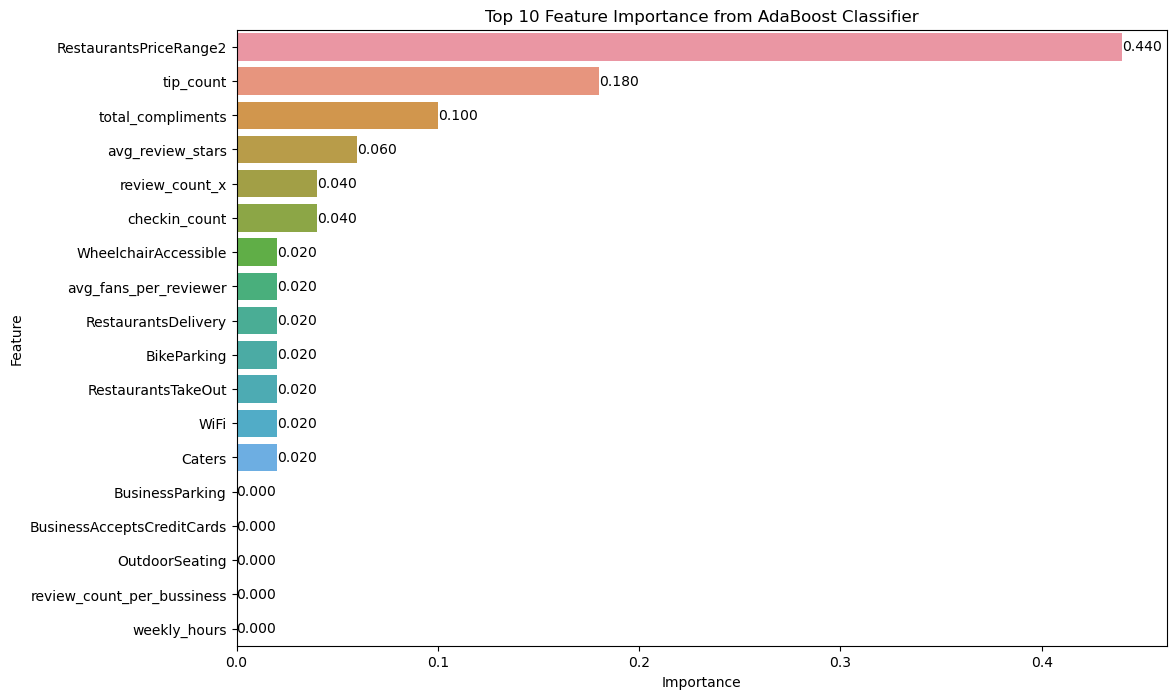

In [209]:
# Get feature importance
importance = ada_boost_classifier.feature_importances_

# Create a DataFrame for feature importance
feature_names = X_train_encoded.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Set the size of the plot
plt.figure(figsize=(12, 8))

# Create a bar plot
sns.barplot(x='Importance', y='Feature', data=importance_df)

# Add titles and labels
plt.title('Top 10 Feature Importance from AdaBoost Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Add the feature importance values beside the bars
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', va='center')  # Format to 4 decimal places


# Show the plot
plt.show()

In [210]:
X_train_smote['RestaurantsPriceRange2']=X_train_smote['RestaurantsPriceRange2'].astype('object')

In [211]:
ada_boost_classifier_2 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42)
ada_boost_classifier_2.fit(X_train_smote, y_train_smote)

c:\Users\LEGION\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   random_state=42)

In [212]:
# Make predictions on the training data
y_train_pred_adab_2 = ada_boost_classifier_2.predict(X_train_smote)

In [213]:
# Calculate and print training accuracy
training_accuracy = accuracy_score(y_train_smote, y_train_pred_adab_2)
print(f"Training Accuracy: {training_accuracy:.4f}")

Training Accuracy: 0.8058


In [214]:
# Predict on val data
y_pred_ada_boost_2 = ada_boost_classifier_2.predict(X_val_encoded)

# Evaluate the model
print("Adaboost Accuracy:", accuracy_score(y_val, y_pred_ada_boost_2))
print(classification_report(y_val, y_pred_ada_boost_2))

Adaboost Accuracy: 0.7537745261057532
              precision    recall  f1-score   support

           0       0.41      0.49      0.45      6130
           1       0.86      0.82      0.84     23940

    accuracy                           0.75     30070
   macro avg       0.64      0.66      0.65     30070
weighted avg       0.77      0.75      0.76     30070



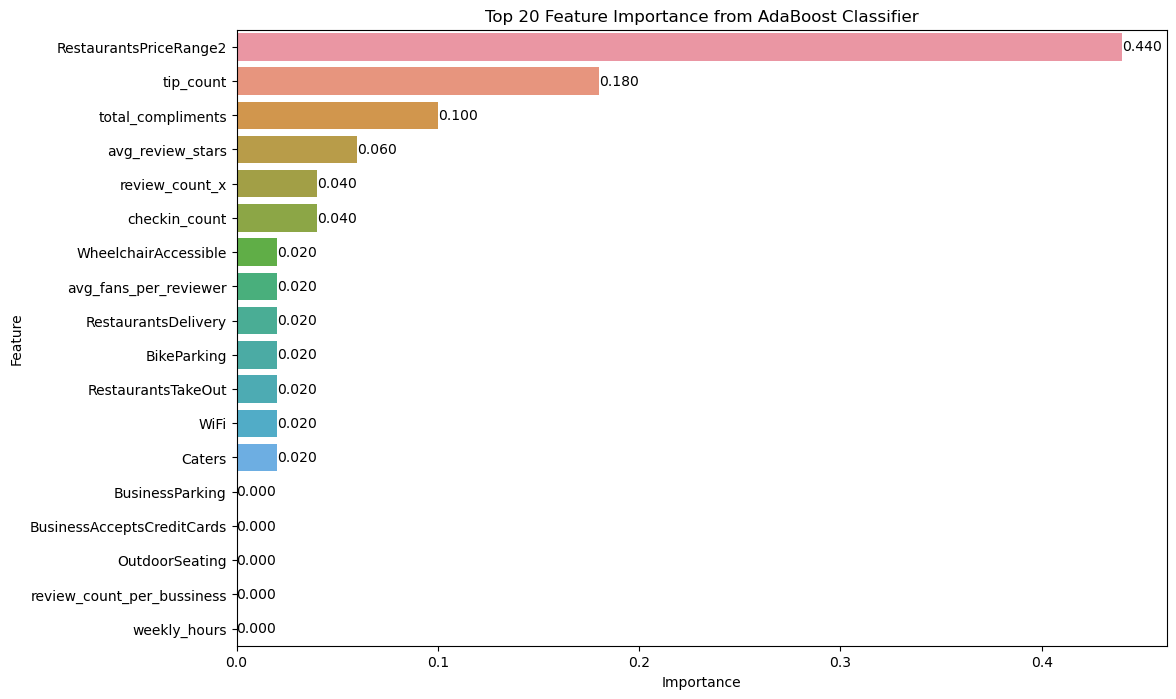

In [215]:
# Get feature importance
importance_2 = ada_boost_classifier_2.feature_importances_

# Create a DataFrame for feature importance
feature_names = X_train_encoded.columns
importance_df_2 = pd.DataFrame({'Feature': feature_names, 'Importance': importance_2})
importance_df_2 = importance_df_2.sort_values(by='Importance', ascending=False).head(20)

# Set the size of the plot
plt.figure(figsize=(12, 8))

# Create a bar plot
sns.barplot(x='Importance', y='Feature', data=importance_df_2)

# Add titles and labels
plt.title('Top 20 Feature Importance from AdaBoost Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Add the feature importance values beside the bars
for index, value in enumerate(importance_df_2['Importance']):
    plt.text(value, index, f'{value:.3f}', va='center')  # Format to 4 decimal places


# Show the plot
plt.show()

In [216]:
X_train_smote['RestaurantsPriceRange2']=X_train_smote['RestaurantsPriceRange2'].astype('category')

In [217]:
ada_boost_classifier_3 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42)
ada_boost_classifier_3.fit(X_train_smote, y_train_smote)

c:\Users\LEGION\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   random_state=42)

In [218]:
# Make predictions on the training data
y_train_pred_adab_3 = ada_boost_classifier_3.predict(X_train_smote)

In [219]:
# Calculate and print training accuracy
training_accuracy = accuracy_score(y_train_smote, y_train_pred_adab_3)
print(f"Training Accuracy: {training_accuracy:.4f}")

Training Accuracy: 0.8058


In [220]:
# Predict on val data
y_pred_ada_boost_3 = ada_boost_classifier_3.predict(X_val_encoded)

# Evaluate the model
print("Adaboost Accuracy:", accuracy_score(y_val, y_pred_ada_boost_3))
print(classification_report(y_val, y_pred_ada_boost_3))

Adaboost Accuracy: 0.7537745261057532
              precision    recall  f1-score   support

           0       0.41      0.49      0.45      6130
           1       0.86      0.82      0.84     23940

    accuracy                           0.75     30070
   macro avg       0.64      0.66      0.65     30070
weighted avg       0.77      0.75      0.76     30070



Empirical Tuning

Instance 1

In [222]:
from sklearn.model_selection import GridSearchCV

base_estimator = DecisionTreeClassifier()

param_grid = {
    'n_estimators': [50,100],
    'learning_rate': [0.01, 0.1]
}

grid_search_adab = GridSearchCV(AdaBoostClassifier(estimator=base_estimator),
                                param_grid=param_grid,
                                scoring='accuracy',
                                cv=5)
grid_search_adab.fit(X_train_smote, y_train_smote)

c:\Users\LEGION\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LEGION\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LEGION\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LEGION\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

In [45]:
# Get the best parameters and the best score
best_params = grid_search_adab.best_params_
best_score = grid_search_adab.best_score_

print("Best Parameters: ", best_params)
print("Best Cross-Validation Score: {:.4f}".format(best_score))

Best Parameters:  {'learning_rate': 0.01, 'n_estimators': 50}
Best Cross-Validation Score: 0.7894


Instance 2

In [46]:
param_grid_1 = {
    'n_estimators': [100,200],
    'learning_rate': [0.05, 0.1, 0.2],
    'base_estimator__max_depth': [1, 2]
}

grid_search_adab_1 = GridSearchCV(AdaBoostClassifier(estimator=base_estimator),
                                param_grid=param_grid_1,
                                scoring='accuracy',
                                cv=5)
grid_search_adab_1.fit(X_train_smote, y_train_smote)

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Param

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier()),
             param_grid={'base_estimator__max_depth': [1, 2],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [47]:
# Get the best parameters and the best score
best_params_1 = grid_search_adab_1.best_params_
best_score_1 = grid_search_adab_1.best_score_

print("Best Parameters: ", best_params_1)
print("Best Cross-Validation Score: {:.4f}".format(best_score_1))

Best Parameters:  {'base_estimator__max_depth': 2, 'learning_rate': 0.2, 'n_estimators': 200}
Best Cross-Validation Score: 0.7990


Instance 3

In [ ]:
param_grid_2 = {
    'n_estimators': [150,200],
    'learning_rate': [0.05, 0.1],
    'base_estimator__max_depth': [1, 2, 3]
}

grid_search_adab_2 = GridSearchCV(AdaBoostClassifier(estimator=base_estimator),
                                param_grid=param_grid_2,
                                scoring='accuracy',
                                cv=5)
grid_search_adab_2.fit(X_train_smote, y_train_smote)

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Param

In [ ]:
# Get the best parameters and the best score
best_params_2 = grid_search_adab_2.best_params_
best_score_2 = grid_search_adab_2.best_score_

print("Best Parameters: ", best_params_2)
print("Best Cross-Validation Score: {:.4f}".format(best_score_2))

Selecting best model after Grid Search CV

In [ ]:
best_model = grid_search_adab_2.best_estimator_
val_score = best_model.score(X_val, y_val)
print("Validation score with best model:", val_score)

Accuracy (Best model)

In [ ]:
# Predict on best model
y_pred_dt = best_model.predict(X_test_encoded)

# Evaluate the model
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Model Interpretation using LIME

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Now use X_train_scaled and X_test_scaled for LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_scaled,  # Scaled training data
    feature_names=X_train_encoded.columns,  # Feature names
    class_names=['Not Validated', 'Validated'],  # Adjust based on your problem
    mode='classification'
)

# Pick a sample from the test set to explain
i = 10
sample = X_test_scaled[i].reshape(1, -1)

# Generate explanation
exp = explainer.explain_instance(
    data_row=X_test_scaled[i],  # Scaled instance to explain
    predict_fn=best_model.predict_proba  # Prediction function
)

# Show explanation
exp.show_in_notebook(show_table=True)

Model Interpretation using SHAP

In [ ]:
shap_explainer = shap.KernelExplainer(ada_boost_classifier.predict_proba, X_train_encoded)

first_row = X_train_encoded.iloc[0]
input_data = pd.DataFrame([first_row.values], columns=X_train_encoded.columns)

# Calculate SHAP values
shap_values = shap_explainer.shap_values(input_data)

# Plot SHAP values
plt.figure()
shap.initjs()
shap.summary_plot(shap_values, input_data, feature_names=feature_names, show=False)